In [1]:
#!pip uninstall featuretools
#!pip install featuretools[complete]
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold,KFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading datasets

In [2]:
train = pd.read_csv("/content/drive/My Drive/CustomerSegmentation_JH/Train_aBjfeNk.csv")
test = pd.read_csv("/content/drive/My Drive/CustomerSegmentation_JH/Test_LqhgPWU.csv")  
submission = pd.read_csv("/content/drive/My Drive/CustomerSegmentation_JH/sample_submission_wyi0h0z.csv")

## Helpful Methods

In [3]:
def print_score(m):
  all_metrics = [m.score(X_train,y_train),m.score(X_valid,y_valid)]
  if hasattr(m,"oob_score"):
    all_metrics.append(m.oob_score)
  return all_metrics 

## Analysing datasets

### Checking NA values

In [4]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [6]:
print(train.isnull().sum())
print("--------------------")
print(test.isnull().sum())

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64
--------------------
ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64


In [7]:
def combined_df(train,test):
  train['is_train'] = 1
  test['is_train'] = 0
  return pd.concat([train,test],axis=0)

In [8]:
combined = combined_df(train,test)

In [9]:
combined.isnull().sum()

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
is_train              0
dtype: int64

In [10]:
## METHOD TO FILL NULL VALUES
## I could see some of the customers whose age is 50+ also has Graduated as No 
## It is difficult to fill the graduated as yes or no based on age. Hence it is better to fill the mode
## Ever married and family size go hand in hand with each other. But the customer can live with parents as well
## Work experience also has anamoly with 0 when the age is 30+.

In [11]:
combined['Graduated'].value_counts()

Yes    6570
No     4023
Name: Graduated, dtype: int64

(array([  98.,  461.,  958., 1095., 1219.,  657.,  565.,  509.,  266.,
         335.]),
 array([18. , 25.1, 32.2, 39.3, 46.4, 53.5, 60.6, 67.7, 74.8, 81.9, 89. ]),
 <a list of 10 Patch objects>)

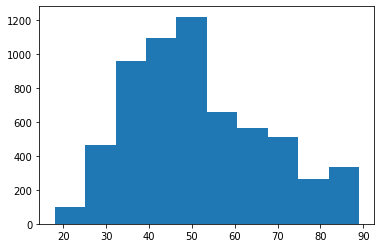

In [12]:
plt.hist(combined[combined['Ever_Married'] == "Yes"]['Age'])
## It is safe to assume that till 25 the chances of getting married is less. Hence we can conditionally fill the values
## When the age < 25, Ever married is No else Yes

(array([ 148., 1018., 1275., 1249., 1154.,  567.,  453.,  341.,  160.,
         205.]),
 array([18. , 25.1, 32.2, 39.3, 46.4, 53.5, 60.6, 67.7, 74.8, 81.9, 89. ]),
 <a list of 10 Patch objects>)

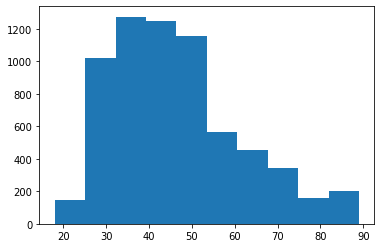

In [13]:
plt.hist(combined[combined['Graduated'] == "Yes"]['Age'])
## It is safe to assume that till 25 the chances of getting graudated is less. Hence we can conditionally fill the values
## When the age < 25, Graduated is No else Yes

In [14]:
conditions = [combined['Age'] < 25, combined['Age'] >= 25]
values = ['No','Yes']

# apply logic where ever_married is null
combined['Ever_Married'] = np.where(combined['Ever_Married'].isnull(),
                              np.select(conditions, values),
                              combined['Ever_Married'])
combined['Graduated'] = np.where(combined['Graduated'].isnull(),
                              np.select(conditions, values),
                              combined['Graduated'])

In [15]:
combined['Profession'].value_counts()

Artist           3318
Healthcare       1750
Entertainment    1250
Engineer          935
Doctor            930
Lawyer            844
Executive         775
Marketing         403
Homemaker         328
Name: Profession, dtype: int64

In [16]:
## We may not know the Profession at all. Lets fill "others"
combined['Profession'].fillna("Others",inplace=True)

In [17]:
combined.isnull().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
is_train              0
dtype: int64

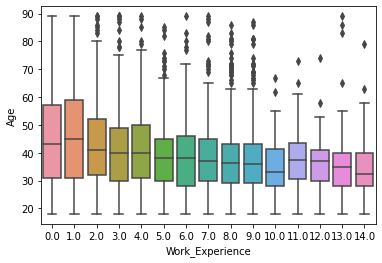

In [18]:
sns.boxplot(combined['Work_Experience'],combined['Age'])
## Right from having 0 work experience till 14 years of experience, the median age always lies close to 35-45
## Also When the work experience is more, the bottom whisker also touches 20 age which is a serious anamoly
## Hence we can fill mode value

In [19]:
combined['Work_Experience'].mode()

0    1.0
dtype: float64

In [20]:
combined['Work_Experience'].fillna(1,inplace=True)

In [21]:
combined.isnull().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience       0
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
is_train              0
dtype: int64

In [22]:
combined['Family_Size'].value_counts()
combined['Family_Size'].fillna(2,inplace=True) ## Filling the mode

In [23]:
combined.isnull().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience       0
Spending_Score        0
Family_Size           0
Var_1               108
Segmentation       2627
is_train              0
dtype: int64

In [24]:
combined['Var_1'].value_counts()
## Lets fill this anonymised category as "Cat_Unknown" as there is only 108 null values
combined['Var_1'].fillna("Cat_Unknown",inplace=True)

In [25]:
combined.isnull().sum()

ID                    0
Gender                0
Ever_Married          0
Age                   0
Graduated             0
Profession            0
Work_Experience       0
Spending_Score        0
Family_Size           0
Var_1                 0
Segmentation       2627
is_train              0
dtype: int64

## Feature Engineering FT Tools

In [ ]:
import featuretools as ft
import featuretools.variable_types as vtypes

In [ ]:
combined['index'] = np.arange(len(combined))

In [ ]:
segments = combined['Segmentation']
is_train = combined['is_train']
combined.drop(['Segmentation','is_train'], axis=1, inplace=True)

In [ ]:
es = ft.EntitySet(id = 'customer')

In [ ]:
variable_types = { 'Gender': vtypes.Categorical,
                  'Ever_Married': vtypes.Categorical,
                  'Graduated': vtypes.Categorical,
                  'Profession': vtypes.Categorical,
                  'Spending_Score': vtypes.Categorical,
                  'Var_1': vtypes.Categorical,
                  }

In [ ]:
combined.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,index
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,0
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,1
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,2
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,3
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,4


In [ ]:
es.entity_from_dataframe(entity_id = 'data', dataframe = combined, 
                        index = 'index',variable_types=variable_types)
feature_matrix, feature_list = ft.dfs(entityset = es, target_entity = 'data',max_depth=3,
                                      agg_primitives=["mode"],
                                      )
main2=feature_matrix

/usr/local/lib/python3.6/dist-packages/featuretools/synthesis/dfs.py:313: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['mode']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


In [ ]:
main2

,ID,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
index,,,,,,,,,,
0,462809,22,1.0,4.0,Male,No,No,Healthcare,Low,Cat_4
1,462643,38,1.0,3.0,Female,Yes,Yes,Engineer,Average,Cat_4
2,466315,67,1.0,1.0,Female,Yes,Yes,Engineer,Low,Cat_6
3,461735,67,0.0,2.0,Male,Yes,Yes,Lawyer,High,Cat_6
4,462669,40,1.0,6.0,Female,Yes,Yes,Entertainment,High,Cat_6
...,...,...,...,...,...,...,...,...,...,...
10690,467954,29,9.0,4.0,Male,No,No,Healthcare,Low,Cat_6
10691,467958,35,1.0,1.0,Female,No,Yes,Doctor,Low,Cat_6
10692,467960,53,1.0,2.0,Female,No,Yes,Entertainment,Low,Cat_6


In [ ]:
feature_list

[<Feature: ID>,
 <Feature: Age>,
 <Feature: Work_Experience>,
 <Feature: Family_Size>,
 <Feature: Gender>,
 <Feature: Ever_Married>,
 <Feature: Graduated>,
 <Feature: Profession>,
 <Feature: Spending_Score>,
 <Feature: Var_1>]

## Feature Engineering

In [ ]:
# combined['Age_qcut'] = pd.qcut(combined['Age'], 6)
# combined['Work_Experience_qcut'] = pd.qcut(combined['Work_Experience'], 3,duplicates="drop")

In [26]:
combined['Work_start_age'] = combined['Age'] - combined['Work_Experience']

In [27]:
combined['Family_Size_Excl_customer'] = combined['Family_Size'] - 1

In [28]:
x = pd.cut(combined['Age'],11)

In [29]:
x.categories = [1,2,3,4,5,6,7,8,9,10,11]

In [30]:
combined['age_category'] = x

In [31]:
combined['age_category'] = combined['age_category'].cat.codes

In [32]:
combined.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,is_train,Work_start_age,Family_Size_Excl_customer,age_category
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,1,21.0,3.0,0
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A,1,37.0,2.0,3
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,1,66.0,0.0,7
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B,1,67.0,1.0,7
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A,1,39.0,5.0,3


## Modelling

In [103]:
ohe_combined = pd.get_dummies(combined,columns=['Gender','Ever_Married','Profession','Var_1'])

In [104]:
combined['Spending_Score'].value_counts()

Low        6494
Average    2599
High       1602
Name: Spending_Score, dtype: int64

In [105]:
Graduate_Mapping = {"Yes":1,"No":0}
Spending_Mapping = {"Low":0,'Average':1,'High':2}

In [106]:
ohe_combined['Graduated'] = ohe_combined['Graduated'].map(Graduate_Mapping)
ohe_combined['Spending_Score'] = ohe_combined['Spending_Score'].map(Spending_Mapping)

In [107]:
def normalize(df,features):
    result = df.copy()
    max_value = df[features].max()
    min_value = df[features].min()
    features_normalized = features +"_Normalized"
    result[features_normalized] = (df[features] - min_value) / (max_value - min_value)
    return result

ohe_combined = normalize(ohe_combined,"Age")
ohe_combined = normalize(ohe_combined,"Work_Experience")
ohe_combined = normalize(ohe_combined,"Family_Size")
ohe_combined = normalize(ohe_combined,"Work_start_age")
ohe_combined = normalize(ohe_combined,"Family_Size_Excl_customer")

In [108]:
ohe_combined.head()

,ID,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Segmentation,is_train,Work_start_age,Family_Size_Excl_customer,age_category,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Others,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_Cat_Unknown,Age_Normalized,Work_Experience_Normalized,Family_Size_Normalized,Work_start_age_Normalized,Family_Size_Excl_customer_Normalized
0,462809,22,0,1.0,0,4.0,D,1,21.0,3.0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.056338,0.071429,0.375,0.200000,0.375
1,462643,38,1,1.0,1,3.0,A,1,37.0,2.0,3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.281690,0.071429,0.250,0.388235,0.250
2,466315,67,1,1.0,0,1.0,B,1,66.0,0.0,7,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.690141,0.071429,0.000,0.729412,0.000
3,461735,67,1,0.0,2,2.0,B,1,67.0,1.0,7,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.690141,0.000000,0.125,0.741176,0.125
4,462669,40,1,1.0,2,6.0,A,1,39.0,5.0,3,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.309859,0.071429,0.625,0.411765,0.625


In [109]:
ohe_combined['Spend_Family'] = ohe_combined['Spending_Score'] * ohe_combined['Family_Size_Excl_customer_Normalized']

In [148]:
ohe_combined['Work_Spend_Score'] = ohe_combined['Spending_Score'] * ohe_combined['Work_Experience_Normalized']

In [167]:
ohe_combined

,ID,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Segmentation,is_train,Work_start_age,Family_Size_Excl_customer,age_category,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Others,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_Cat_Unknown,Age_Normalized,Work_Experience_Normalized,Family_Size_Normalized,Work_start_age_Normalized,Family_Size_Excl_customer_Normalized,Spend_Family,Work_Spend_Score
0,462809,22,0,1.0,0,4.0,D,1,21.0,3.0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.056338,0.071429,0.375,0.200000,0.375,0.00,0.000000
1,462643,38,1,1.0,1,3.0,A,1,37.0,2.0,3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.281690,0.071429,0.250,0.388235,0.250,0.25,0.071429
2,466315,67,1,1.0,0,1.0,B,1,66.0,0.0,7,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.690141,0.071429,0.000,0.729412,0.000,0.00,0.000000
3,461735,67,1,0.0,2,2.0,B,1,67.0,1.0,7,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.690141,0.000000,0.125,0.741176,0.125,0.25,0.000000
4,462669,40,1,1.0,2,6.0,A,1,39.0,5.0,3,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.309859,0.071429,0.625,0.411765,0.625,1.25,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,29,0,9.0,0,4.0,NaN,0,20.0,3.0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.154930,0.642857,0.375,0.188235,0.375,0.00,0.000000
2623,467958,35,1,1.0,0,1.0,NaN,0,34.0,0.0,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.239437,0.071429,0.000,0.352941,0.000,0.00,0.000000
2624,467960,53,1,1.0,0,2.0,NaN,0,52.0,1.0,5,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.492958,0.071429,0.125,0.564706,0.125,0.00,0.000000
2625,467961,47,1,1.0,2,5.0,NaN,0,46.0,4.0,4,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.408451,0.071429,0.500,0.494118,0.500,1.00,0.142857


## Dataframe

In [149]:
train_df = ohe_combined[combined['is_train'] == 1]
test_df = ohe_combined[combined['is_train'] == 0]

In [150]:
train_df.drop("is_train",axis=1,inplace=True)
test_df.drop(["is_train","Segmentation"],axis=1,inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [151]:
train_df.drop("ID",axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [152]:
train_df['Segmentation'].value_counts()

D    2268
A    1972
C    1970
B    1858
Name: Segmentation, dtype: int64

In [153]:
Segmentation_Mapping = {"A":0,'B':1,'C':2,'D':3}

In [154]:
train_df['Segmentation'] = train_df['Segmentation'].map(Segmentation_Mapping)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [155]:
train_df.columns

Index(['Age', 'Graduated', 'Work_Experience', 'Spending_Score', 'Family_Size',
       'Segmentation', 'Work_start_age', 'Family_Size_Excl_customer',
       'age_category', 'Gender_Female', 'Gender_Male', 'Ever_Married_No',
       'Ever_Married_Yes', 'Profession_Artist', 'Profession_Doctor',
       'Profession_Engineer', 'Profession_Entertainment',
       'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker',
       'Profession_Lawyer', 'Profession_Marketing', 'Profession_Others',
       'Var_1_Cat_1', 'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4',
       'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7', 'Var_1_Cat_Unknown',
       'Age_Normalized', 'Work_Experience_Normalized',
       'Family_Size_Normalized', 'Work_start_age_Normalized',
       'Family_Size_Excl_customer_Normalized', 'Spend_Family',
       'Work_Spend_Score'],
      dtype='object')

In [117]:
X = train_df.drop(["Age","Work_Experience","Family_Size","Segmentation",'Work_start_age', 'Family_Size_Excl_customer'],axis=1)
y = train_df['Segmentation']

In [118]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=42)

In [56]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

## Keras

In [50]:
X_train.shape

(6454, 30)

In [80]:
def baseline_model():
  model=Sequential()
  model.add(Dense(16,input_dim=30,activation='relu'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(4,activation='softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
  return model

In [92]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=100, verbose=True)

In [93]:
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
7261/7261 [==============================] - 0s 29us/step - loss: 1.3345 - accuracy: 0.3948
Epoch 2/100
7261/7261 [==============================] - 0s 15us/step - loss: 1.2059 - accuracy: 0.4678
Epoch 3/100
7261/7261 [==============================] - 0s 14us/step - loss: 1.1418 - accuracy: 0.4990
Epoch 4/100
7261/7261 [==============================] - 0s 16us/step - loss: 1.1113 - accuracy: 0.5081
Epoch 5/100
7261/7261 [==============================] - 0s 16us/step - loss: 1.0953 - accuracy: 0.5155
Epoch 6/100
7261/7261 [==============================] - 0s 14us/step - loss: 1.0834 - accuracy: 0.5167
Epoch 7/100
7261/7261 [==============================] - 0s 15us/step - loss: 1.0750 - accuracy: 0.5184
Epoch 8/100
7261/7261 [==============================] - 0s 14us/step - loss: 1.0704 - accuracy: 0.5218
Epoch 9/100
7261/7261 [==============================] - 0s 15us/step - loss: 1.0651 - accuracy: 0.5261
Epoch 10/100
7261/7261 [==============================] - 0s 14u

In [94]:
X_test = test_df.drop(["ID","Age","Work_Experience","Family_Size",'Work_start_age', 'Family_Size_Excl_customer'],axis=1)

In [95]:
estimator.fit(X,y)

Epoch 1/100
8068/8068 [==============================] - 0s 29us/step - loss: 1.3545 - accuracy: 0.3563
Epoch 2/100
8068/8068 [==============================] - 0s 15us/step - loss: 1.2088 - accuracy: 0.4549
Epoch 3/100
8068/8068 [==============================] - 0s 16us/step - loss: 1.1396 - accuracy: 0.4896
Epoch 4/100
8068/8068 [==============================] - 0s 17us/step - loss: 1.1105 - accuracy: 0.5048
Epoch 5/100
8068/8068 [==============================] - 0s 15us/step - loss: 1.0961 - accuracy: 0.5128
Epoch 6/100
8068/8068 [==============================] - 0s 15us/step - loss: 1.0871 - accuracy: 0.5143
Epoch 7/100
8068/8068 [==============================] - 0s 14us/step - loss: 1.0819 - accuracy: 0.5176
Epoch 8/100
8068/8068 [==============================] - 0s 14us/step - loss: 1.0762 - accuracy: 0.5218
Epoch 9/100
8068/8068 [==============================] - 0s 15us/step - loss: 1.0711 - accuracy: 0.5270
Epoch 10/100
8068/8068 [==============================] - 0s 14u

In [96]:
y_pred = estimator.predict(X_test)

2627/2627 [==============================] - 0s 10us/step


In [97]:
submission_data = pd.concat([test_df['ID'],pd.Series(y_pred)],axis=1)

In [98]:
Segmentation_Mapping_Inverse = {0:"A",1:"B",2:"C",3:"D"}

In [99]:
submission_data[0] = submission_data[0].map(Segmentation_Mapping_Inverse)

In [100]:
submission_data.columns = ['ID','Segmentation']

In [101]:
submission_data.to_csv("submission_keras_v3.csv",index=False)

## LGBM

In [119]:
train_df

,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Segmentation,Work_start_age,Family_Size_Excl_customer,age_category,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Others,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_Cat_Unknown,Age_Normalized,Work_Experience_Normalized,Family_Size_Normalized,Work_start_age_Normalized,Family_Size_Excl_customer_Normalized,Spend_Family
0,22,0,1.0,0,4.0,3,21.0,3.0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.056338,0.071429,0.375,0.200000,0.375,0.00
1,38,1,1.0,1,3.0,0,37.0,2.0,3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.281690,0.071429,0.250,0.388235,0.250,0.25
2,67,1,1.0,0,1.0,1,66.0,0.0,7,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.690141,0.071429,0.000,0.729412,0.000,0.00
3,67,1,0.0,2,2.0,1,67.0,1.0,7,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.690141,0.000000,0.125,0.741176,0.125,0.25
4,40,1,1.0,2,6.0,0,39.0,5.0,3,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.309859,0.071429,0.625,0.411765,0.625,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,22,0,0.0,0,7.0,3,22.0,6.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.056338,0.000000,0.750,0.211765,0.750,0.00
8064,35,0,3.0,0,4.0,3,32.0,3.0,2,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.239437,0.214286,0.375,0.329412,0.375,0.00
8065,33,1,1.0,0,1.0,3,32.0,0.0,2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.211268,0.071429,0.000,0.329412,0.000,0.00
8066,27,1,1.0,0,4.0,1,26.0,3.0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.126761,0.071429,0.375,0.258824,0.375,0.00


In [122]:
m1 = lgb.LGBMClassifier(n_estimators=100,learning_rate=0.1)

In [123]:
m1.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [124]:
print_score(m1)  

[0.6743105051131082, 0.5210656753407683]

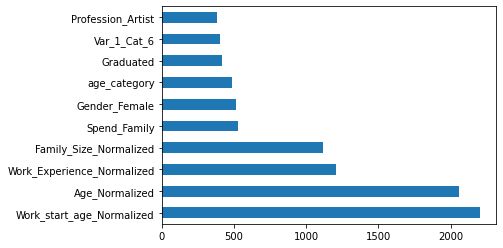

In [125]:
feat_importances = pd.Series(m1.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
y_valid.value_counts()

3    474
0    391
2    380
1    369
Name: Segmentation, dtype: int64

In [ ]:
m1.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
X_test = test_df.drop(["ID","Age","Work_Experience","Family_Size"],axis=1)


In [ ]:
y_pred = m1.predict(X_test)

In [ ]:
submission_data = pd.concat([test_df['ID'],pd.Series(y_pred)],axis=1)

In [ ]:
Segmentation_Mapping_Inverse = {0:"A",1:"B",2:"C",3:"D"}

In [ ]:
submission_data[0] = submission_data[0].map(Segmentation_Mapping_Inverse)

In [ ]:
submission_data.columns = ['ID','Segmentation']

In [ ]:
submission_data.to_csv("submission_v1.csv",index=False)

In [126]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 64.8MB 59kB/s 


In [127]:
train_df

,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Segmentation,Work_start_age,Family_Size_Excl_customer,age_category,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Others,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_Cat_Unknown,Age_Normalized,Work_Experience_Normalized,Family_Size_Normalized,Work_start_age_Normalized,Family_Size_Excl_customer_Normalized,Spend_Family
0,22,0,1.0,0,4.0,3,21.0,3.0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.056338,0.071429,0.375,0.200000,0.375,0.00
1,38,1,1.0,1,3.0,0,37.0,2.0,3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.281690,0.071429,0.250,0.388235,0.250,0.25
2,67,1,1.0,0,1.0,1,66.0,0.0,7,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.690141,0.071429,0.000,0.729412,0.000,0.00
3,67,1,0.0,2,2.0,1,67.0,1.0,7,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.690141,0.000000,0.125,0.741176,0.125,0.25
4,40,1,1.0,2,6.0,0,39.0,5.0,3,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.309859,0.071429,0.625,0.411765,0.625,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,22,0,0.0,0,7.0,3,22.0,6.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.056338,0.000000,0.750,0.211765,0.750,0.00
8064,35,0,3.0,0,4.0,3,32.0,3.0,2,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.239437,0.214286,0.375,0.329412,0.375,0.00
8065,33,1,1.0,0,1.0,3,32.0,0.0,2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.211268,0.071429,0.000,0.329412,0.000,0.00
8066,27,1,1.0,0,4.0,1,26.0,3.0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.126761,0.071429,0.375,0.258824,0.375,0.00


In [128]:
test_df

,ID,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Work_start_age,Family_Size_Excl_customer,age_category,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Others,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_Cat_Unknown,Age_Normalized,Work_Experience_Normalized,Family_Size_Normalized,Work_start_age_Normalized,Family_Size_Excl_customer_Normalized,Spend_Family
0,458989,36,1,0.0,0,1.0,36.0,0.0,2,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.253521,0.000000,0.000,0.376471,0.000,0.000
1,458994,37,1,8.0,1,4.0,29.0,3.0,2,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.267606,0.571429,0.375,0.294118,0.375,0.375
2,458996,69,0,0.0,0,1.0,69.0,0.0,7,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.718310,0.000000,0.000,0.764706,0.000,0.000
3,459000,59,0,11.0,2,2.0,48.0,1.0,6,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.577465,0.785714,0.125,0.517647,0.125,0.250
4,459001,19,0,1.0,0,4.0,18.0,3.0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.014085,0.071429,0.375,0.164706,0.375,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,29,0,9.0,0,4.0,20.0,3.0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.154930,0.642857,0.375,0.188235,0.375,0.000
2623,467958,35,1,1.0,0,1.0,34.0,0.0,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.239437,0.071429,0.000,0.352941,0.000,0.000
2624,467960,53,1,1.0,0,2.0,52.0,1.0,5,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.492958,0.071429,0.125,0.564706,0.125,0.000
2625,467961,47,1,1.0,2,5.0,46.0,4.0,4,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.408451,0.071429,0.500,0.494118,0.500,1.000


## Catboost kfold

In [156]:

K = 5
kf = KFold(n_splits = K, random_state = 7, shuffle = True)
skf = StratifiedKFold(n_splits = K, random_state = 7, shuffle = True)

In [157]:
MAX_ROUNDS = 1000
OPTIMIZE_ROUNDS = False

In [158]:
from sklearn.metrics import accuracy_score

In [159]:
X

,Graduated,Spending_Score,age_category,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Others,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_Cat_Unknown,Work_start_age_Normalized,Family_Size_Excl_customer_Normalized,Spend_Family
0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.200000,0.375,0.00
1,1,1,3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.388235,0.250,0.25
2,1,0,7,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.729412,0.000,0.00
3,1,2,7,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.741176,0.125,0.25
4,1,2,3,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.411765,0.625,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.211765,0.750,0.00
8064,0,0,2,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.329412,0.375,0.00
8065,1,0,2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.329412,0.000,0.00
8066,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.258824,0.375,0.00


In [160]:
X = train_df.drop(columns=['Segmentation','Age','Work_Experience','Family_Size',
                            'Work_start_age','Family_Size_Excl_customer','Age_Normalized',
                           'Work_Experience_Normalized','Family_Size_Normalized'],axis=1)
y = train_df['Segmentation']
X_test = test_df.drop(columns=['ID','Age','Work_Experience','Family_Size',
                               'Work_start_age','Family_Size_Excl_customer','Age_Normalized',
                           'Work_Experience_Normalized','Family_Size_Normalized'],axis=1)
y_valid_pred = 0*y
y_test_pred = 0
accuracy = 0
result={}
cat_columns = []
j=1
model = CatBoostClassifier(n_estimators=MAX_ROUNDS,verbose=False)
for i, (train_index, test_index) in enumerate(kf.split(train)):
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    print("\nFold - ", j)
    
    if OPTIMIZE_ROUNDS:
        fit_model = model.fit( X_train, y_train, 
                               eval_set=[X_valid, y_valid],cat_features=cat_columns,
                               use_best_model=True
                             )
        print( "N trees = ", model.tree_count_ )
    else:
        fit_model = model.fit( X_train, y_train,cat_features=cat_columns )
        
    pred = fit_model.predict(X_valid)
    y_valid_pred.iloc[test_index] = pred.reshape(-1)
    print(accuracy_score(y_valid,pred))
    accuracy+=accuracy_score(y_valid,pred)
    y_test_pred += fit_model.predict(X_test)
    result[j]=fit_model.predict(X_test)
    j+=1
results = y_test_pred / K  # Average test set predictions
print(accuracy/5)


Fold -  1
0.5074349442379182

Fold -  2
0.530359355638166

Fold -  3
0.5247831474597274

Fold -  4
0.5145691258524488

Fold -  5
0.5164290142591444
0.518715117489481


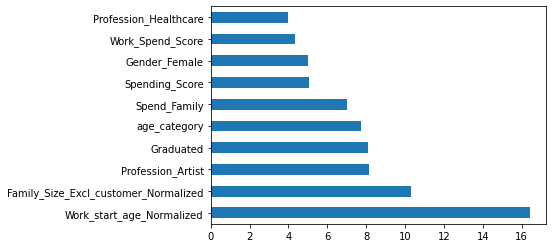

In [166]:
feat_importances = pd.Series(fit_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [161]:
red = pd.DataFrame()
for i in range(1, 6):
    red = pd.concat([red,pd.DataFrame(result[i])],axis=1)
red.columns=['1','2','3','4','5']

In [162]:
final = pd.DataFrame(data=test_df['ID'], index=None)

In [163]:
final['Segmentation'] = red.mode(axis=1)[0]

In [164]:
final['Segmentation'] = final['Segmentation'].map(Segmentation_Mapping_Inverse)

In [165]:
final.to_csv("kfold_catboost_v3.csv",index=False)